# Composable AI systems: Building and AI Stylist Specialist selling our products

## What's a composable AI system

LLMs are great at answering generated questions. However, this alone isn't enough to provide value to your customers.

To be able to provide valuable answers, extra information is requred, specific to the user (your customer contract ID, the last email they sent to your support, your most recent sales report etc.).

Composable AI systems are designed to answer this challenge. They are more advanced AI deployments, composed of multiple entities (tools) specialized in different action (retrieving information or acting on external systems). <br/>

At a high level, you build & present a set of custom functions to the AI. The LLM can then reason about it, deciding which tool should be called and information gathered to answer the customer need.

## Building Composable AI Systems with Databricks Mosaic AI agent framework


Databricks simplifies this by providing a built-in service to:

- Create and store your functions (tools) leveraging UC
- Execute the functions in a safe way
- Reason about the tools you selected and chain them together to properly answer your question. 

At a high level, here is the AI system we will implement in this demo:

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/llm-tools-functions/llm-tools-functions-flow.png?raw=true" width="900px">


<!-- Collect usage data (view). Remove it to disable collection or disable tracker during installation. View README for more details.  -->
<img width="1px" src="https://ppxrzfxige.execute-api.us-west-2.amazonaws.com/v1/analytics?category=data-science&notebook=00-AI-function-tools-introduction&demo_name=llm-tools-functions&event=VIEW">

In [0]:
%pip install --quiet -U databricks-sdk==0.23.0 langchain-community==0.2.10 langchain-openai==0.1.19 mlflow==2.14.3 faker
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


USE CATALOG `main__build`
using catalog.database `main__build`.`dbdemos_agent_tools`


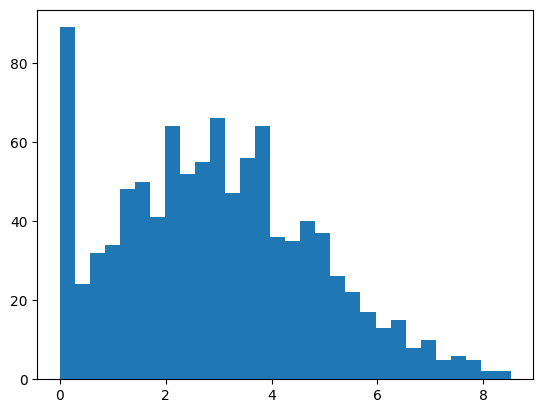

Generated 1662 orders for 1001 users


In [0]:
%run ./_resources/00-init $reset_all=false

## Creating our tools: Using Unity Catalog Functions

Let's start by defining the functions our LLM will be able to execute. These functions can contain any logic, from simple SQL to advanced python.

### Computing Mathematics: converting inches to centimeters

Our online shop is selling across all regions, and we know our customers often ask to convert cm to inches. However, plain LLMs are quite bad at executing math. To solve this, let's create a simple function doing the conversion.

We'll save this function within Unity Catalog. You can open the explorer to review the functions created in this notebook.

*Note: This is a very simple first example for this demo. We'll implement a broader math tool later on.*

In [0]:
%sql
CREATE OR REPLACE FUNCTION convert_inch_to_cm(size_in_inch FLOAT)
RETURNS FLOAT
LANGUAGE SQL
COMMENT 'convert size from inch to cm'
RETURN size_in_inch * 2.54;

-- let's test our function:
SELECT convert_inch_to_cm(10) as 10_inches_in_cm;

10_inches_in_cm
25.4


### Executing a tool to fetch internal data: getting the latest customer orders

We want our stylist assistant to be able to list all existing customer orders

In [0]:
%sql
CREATE OR REPLACE FUNCTION get_customer_orders ()
RETURNS TABLE(user_id STRING,
  id STRING,
  transaction_date STRING,
  item_count DOUBLE,
  amount DOUBLE,
  order_status STRING)
COMMENT 'Returns a list of customer orders for the given customer ID (expect a UUID)'
LANGUAGE SQL
    RETURN
    SELECT o.* from tools_orders o 
    inner join tools_customers c on c.id = o.user_id 
    where email=current_user() ORDER BY transaction_date desc;

SELECT * FROM get_customer_orders();

user_id,id,transaction_date,item_count,amount,order_status
d8ca793f-7f06-42d3-be1b-929e32fc8bc9,7fcdce45-d3f5-46e6-9e25-1305feeef3fd,08-17-2024 10:00:39,2.0,24.0,Shipped
d8ca793f-7f06-42d3-be1b-929e32fc8bc9,0a7e7840-ea48-4bf4-8f74-143d0bab128e,08-09-2024 10:11:11,3.0,87.0,Shipped
d8ca793f-7f06-42d3-be1b-929e32fc8bc9,b69545e8-e432-473a-a4db-b18b759d1e56,08-07-2024 07:38:38,2.0,36.0,Pending
d8ca793f-7f06-42d3-be1b-929e32fc8bc9,0c4bcd6e-48c9-4b83-bf1a-108d2fda5dbd,08-05-2024 22:23:47,3.0,42.0,Pending


### Executing a Python function to fetch external dataset in realtime: getting the weather

We want our stylist assistant to give us recommendations based on the weather. Let's add a tool to fetch the weather based on longitude/latitude, using Python to call an external Weather API.

In [0]:
%sql
CREATE OR REPLACE FUNCTION get_weather(latitude DOUBLE, longitude DOUBLE)
RETURNS STRUCT<temperature_in_celsius DOUBLE, rain_in_mm DOUBLE>
LANGUAGE PYTHON
COMMENT 'This function retrieves the current temperature and rain information for a given latitude and longitude using the Open-Meteo API.'
AS
$$
  try:
    import requests as r
    #Note: this is provided for education only, non commercial - please get a license for real usage: https://api.open-meteo.com. Let s comment it to avoid issues for now
    #weather = r.get(f'https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,rain&forecast_days=1').json()
    return {
      "temperature_in_celsius": weather["current"]["temperature_2m"],
      "rain_in_mm": weather["current"]["rain"]
    }
  except:
    return {"temperature_in_celsius": 25.0, "rain_in_mm": 0.0}
$$;

-- let's test our function:
SELECT get_weather(52.52, 13.41) as weather;

weather
"List(25.0, 0.0)"


### Creating a function calling LLMs with specific prompt as a tool

You can also register tools containing custom prompts that your LLM can use to to execute actions based on the customer context.

Let's create a tool that recommend the style for our user, based on the current weather.

In [0]:
%sql
CREATE OR REPLACE FUNCTION recommend_outfit_description(requested_style STRING, temperature_in_celsius FLOAT, rain_in_mm FLOAT)
RETURNS STRING
LANGUAGE SQL
COMMENT 'This function generate a stylist outfit description based on initial request and the current weather.'
RETURN SELECT ai_query('databricks-meta-llama-3-70b-instruct',
    CONCAT("You are a stylist assistant. Your goal is to give recommendation on what would be the best outfit for today. The current temperature is ",temperature_in_celsius ," celsius and rain is:", rain_in_mm, "mm. Give size in inches if any. Don't assume customer size if they don't share it. Give ideas of colors and other items to match. The user added this instruction based on what they like: ", requested_style)
  ) AS recommended_outfit;

-- let's test our function:
SELECT recommend_outfit_description("I need a dress for an interview.", 30.1, 0.0)

"main__build.dbdemos_agent_tools.recommend_outfit_description(I need a dress for an interview., 30.1, 0.0)"
"Perfect weather for a stylish and confident interview outfit! Considering the warm temperature (30.1°C) and no rain, I'd recommend a lightweight, breathable, and professional dress. Here are a few ideas: **Dress Suggestions:** 1. **Shift Dress**: A classic, easy-to-wear option. Look for a knee-length or just above the knee shift dress in a lightweight fabric like cotton, silk, or a cotton-blend. 2. **A-Line Dress**: A flattering and versatile choice. An A-line dress will skim over the body, creating a professional silhouette. 3. **Sheath Dress**: A fitted, knee-length dress that will accentuate your figure. Perfect for making a confident impression. **Color Palette:** For an interview, it's best to stick with neutral or muted colors that exude professionalism. Consider: 1. **Navy Blue**: A classic, timeless choice that's perfect for an interview. 2. **Black**: A versatile and chic option that's easy to pair with accessories. 3. **Gray**: A balanced, neutral color that will make you look polished and professional. **Additional Tips:** * Pair your dress with a pair of low to moderate heels (2-3 inches) to add a touch of sophistication. * Add a simple, classic watch and a pair of stud earrings to complete your outfit. * Consider a lightweight blazer or cardigan to layer over your dress, in case the interview room is air-conditioned. **Size:** Please share your size (bust, waist, and length) so I can provide more tailored recommendations. Which of these dress styles and colors resonates with you?"


### Using Vector search to find similar content as a tool

Let's now add a tool to recomment similar items, based on an article description.

We'll be using Databricks Vector Search to perform a realtime similarity search and return articles that we could suggest from our database.

To do so, you can leverage the new `vector_search` SQL function. See [Documentation](https://docs.databricks.com/en/sql/language-manual/functions/vector_search.html) for more details.

<div style="background-color: #e3efff"> To simplify this demo, we'll fake the call to the vector_search and make it work without pre-loading the demo</div>

In [0]:
%sql
-- Commenting this as the index isn't pre-loaded in the demo to simplify the experience.
-- CREATE OR REPLACE FUNCTION find_clothes_matching_description (description STRING)
-- RETURNS TABLE (category STRING, color STRING, id STRING, price DOUBLE, search_score DOUBLE)
-- LANGUAGE SQL
-- COMMENT 'Finds clothes in our catalog matching the description using AI query and returns a table of results.'
-- RETURN
--  SELECT * FROM VECTOR_SEARCH(index => 'catalog.schema.clothing_index', query => query, num_results => 3) vs


In [0]:
%sql
-- Generate fake data instead of calling the VS index with vector_search;
CREATE OR REPLACE FUNCTION find_clothes_matching_description (description STRING)
RETURNS TABLE (id BIGINT, name STRING, color STRING, category STRING, price DOUBLE, description STRING)
COMMENT 'Finds existing clothes in our catalog matching the description using AI query and returns a table of results.'
RETURN
SELECT clothes.* FROM (
  SELECT explode(from_json(
    ai_query(
      'databricks-meta-llama-3-70b-instruct', 
      CONCAT(
        'returns a json list of 3 json object clothes: <"id": bigint, "name": string, "color": string, "category": string, "price": double, "description": string>. These clothes should match the following user description: ', description, '. Return only the answer as a javascript json object ready to be parsed, no comment or text or javascript or ``` at the beginning.' ) ), 'ARRAY<STRUCT<id: BIGINT, name: STRING, color: STRING, category: STRING, price: DOUBLE, description: STRING>>' )) AS clothes );

-- let's test our function:
SELECT * FROM find_clothes_matching_description('a red dress');

id,name,color,category,price,description
1,Red Evening Gown,Red,Dress,120.0,A stunning red evening gown perfect for formal events.
2,Crimson Sundress,Red,Dress,80.0,A bright and cheerful red sundress ideal for summer outings.
3,Ruby Red Bodycon,Red,Dress,90.0,A sleek and sexy red bodycon dress perfect for a night out.


## Using Databricks Playground to test our functions

Databricks Playground provides a built-in integration with your functions. It'll analyze which functions are available, and call them to properly answer your question.


<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/llm-tools-functions/llm-tools-functions-playground.gif?raw=true" style="float: right; margin-left: 10px; margin-bottom: 10px;">

To try out our functions with playground:
- Open the Playground 
- Select a model supporting tools (like Llama3.1)
- Add the functions you want your model to leverage (`catalog.schema.function_name`)
- Ask a question (for example to convert inch to cm), and playground will do the magic for you!

<br/>
<div style="background-color: #d4e7ff; padding: 10px; border-radius: 15px;clear:both">
<strong>Note:</strong> Tools in playground is in preview, reach-out your Databricks Account team for more details and to enable it.
</div>



## Building an AI system leveraging our Databricks UC functions with Langchain

These tools can also directly be leveraged on custom model. In this case, you'll be in charge of chaining and calling the functions yourself (the playground does it for you!)

Langchain makes it easy for you. You can create your own custom AI System using a Langchain model and a list of existing tools (in our case, the tools will be the functions we just created)

### Enable MLflow Tracing

Enabling MLflow Tracing is required to:
- View the chain's trace visualization in this notebook
- Capture the chain's trace in production via Inference Tables
- Evaluate the chain via the Mosaic AI Evaluation Suite

In [0]:
import mlflow
mlflow.langchain.autolog(disable=False)

### Start by creating our tools from Unity Catalog

Let's use UCFunctionToolkit to select which functions we want to use as tool for our demo:

In [0]:
from langchain_community.tools.databricks import UCFunctionToolkit
import pandas as pd
wh = get_shared_warehouse(name = None) #Get the first shared wh we can. See _resources/01-init for details
print(f'This demo will be using the wg {wh.name} to execute the functions')

def get_tools():
    return (
        UCFunctionToolkit(warehouse_id=wh.id)
        # Include functions as tools using their qualified names.
        # You can use "{catalog_name}.{schema_name}.*" to get all functions in a schema.
        .include(f"{catalog}.{db}.*")
        .get_tools())

display_tools(get_tools()) #display in a table the tools - see _resource/00-init for details

This demo will be using the wg dbdemos-shared-endpoint to execute the functions


name,description,args_schema,return_direct,verbose,callbacks,callback_manager,tags,metadata,handle_tool_error,handle_validation_error,response_format,func,coroutine
main__build__dbdemos_agent_tools__compute_math,Run any mathematical function and returns the result as output. Supports python syntax like math.sqrt(13),,False,False,None,None,None,None,False,False,content,.func at 0x7fa8a5343880>,None
main__build__dbdemos_agent_tools__convert_inch_to_cm,convert size from inch to cm,,False,False,None,None,None,None,False,False,content,.func at 0x7fa8a4500180>,None
main__build__dbdemos_agent_tools__execute_python_code,Run any python code and returns the output,,False,False,None,None,None,None,False,False,content,.func at 0x7fa848192840>,None
n__build__dbdemos_agent_tools__find_clothes_matching_description,Finds existing clothes in our catalog matching the description using AI query and returns a table of results.,,False,False,None,None,None,None,False,False,content,.func at 0x7fa848192160>,None
main__build__dbdemos_agent_tools__generate_image,This function generate an images and returns its content as base64.,,False,False,None,None,None,None,False,False,content,.func at 0x7fa8481928e0>,None
main__build__dbdemos_agent_tools__generate_image_with_secret,This function generate an images and returns its content as base64. It also saves the image in the demo volume.,,False,False,None,None,None,None,False,False,content,.func at 0x7fa848192c00>,None
main__build__dbdemos_agent_tools__get_customer_orders,Returns a list of customer orders for the given customer ID (expect a UUID),,False,False,None,None,None,None,False,False,content,.func at 0x7fa848192d40>,None
main__build__dbdemos_agent_tools__get_weather,This function retrieves the current temperature and rain information for a given latitude and longitude using the Open-Meteo API.,,False,False,None,None,None,None,False,False,content,.func at 0x7fa848193060>,None
main__build__dbdemos_agent_tools__recommend_outfit_description,This function generate a stylist outfit description based on initial request and the current weather.,,False,False,None,None,None,None,False,False,content,.func at 0x7fa848192fc0>,None


### Let's create our langchain agent using the tools we just created

In [0]:

from langchain_openai import ChatOpenAI
from databricks.sdk import WorkspaceClient

# Note: langchain_community.chat_models.ChatDatabricks doesn't support create_tool_calling_agent yet - it'll soon be availableK. Let's use ChatOpenAI for now
llm = ChatOpenAI(
  base_url=f"{WorkspaceClient().config.host}/serving-endpoints/",
  api_key=dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get(),
  model="databricks-meta-llama-3-70b-instruct"
)


In [0]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatDatabricks

def get_prompt(history = [], prompt = None):
    if not prompt:
            prompt = """You are a helpful fashion assistant. Your task is to recommend cothes to the users. You can use the following tools:
    - Use the convert_inch_to_cm to covert inch to cm if the customer ask for it
    - Use get_customer_orders to get the list of orders and their status, total amount and number of article. 
    - Use find_clothes_matching_description to find existing clothes from our internal catalog and suggest article to the customer
    - Use recommend_outfit if a customer ask you for a style. This function take the weather as parameter. Use the get_weather function first before calling this function to get the current temperature and rain. The current user location is 52.52, 13.41.

    Make sure to use the appropriate tool for each step and provide a coherent response to the user. Don't mention tools to your users. Only answer what the user is asking for. If the question isn't related to the tools or style/clothe, say you're sorry but can't answer"""
    return ChatPromptTemplate.from_messages([
            ("system", prompt),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),
    ])

In [0]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
prompt = get_prompt()
tools = get_tools()
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

### Let's give it a try: Asking to run a simple size conversion.
Under the hood, we want this to call our Math conversion function:

In [0]:
agent_executor.invoke({"input": "what's 12in in cm?"})



> Entering new AgentExecutor chain...

Invoking: `main__build__dbdemos_agent_tools__convert_inch_to_cm` with `{'size_in_inch': 12}`


{"format": "SCALAR", "value": "30.48", "truncated": false}12 inches is equivalent to 30.48 cm.

> Finished chain.


{'input': "what's 12in in cm?",
 'output': '12 inches is equivalent to 30.48 cm.'}

Trace(info=TraceInfo(request_id='tr-26d0b500f7ab4b9e9d33e00ff0764a78', experiment_id='d6e50d4c0c954ee6b55a5e599c91f2b5', timestamp_ms=1724874664457, execution_time_ms=22695, status=<TraceStatus.OK: 'OK'>, request_metadata={'mlflow.trace_schema.version': '2', 'mlflow.traceInputs': '{"input": "what\'s 12in in cm?"}', 'mlflow.traceOutputs': '{"output": "12 inches is equivalent to 30.48 cm."}'}, tags={'mlflow.databricks.notebook.commandID': '1724874440564_8014996527821151036_job-405874226060882-run-789372677712187-action-5961893717104304', 'mlflow.databricks.notebookID': '1954670855488559', 'mlflow.databricks.notebookPath': '/Repos/.internal/def28b02ce_commits/314d8bd064f6aec1e5fa0815e7258da1c45577f3/product_demos/Data-Science/llm-tools-functions/00-AI-function-tools-introduction', 'mlflow.databricks.webappURL': 'https://oregon.cloud.databricks.com', 'mlflow.databricks.workspaceID': '1660015457675682', 'mlflow.databricks.workspaceURL': 'xxxx.cloud.databricks.com', 'mlflow.source.name': 'jo

In [0]:
agent_executor.invoke({"input": "what are my latest orders?"})



> Entering new AgentExecutor chain...

Invoking: `main__build__dbdemos_agent_tools__get_customer_orders` with `{}`


{"format": "CSV", "value": "user_id,id,transaction_date,item_count,amount,order_status\nd8ca793f-7f06-42d3-be1b-929e32fc8bc9,7fcdce45-d3f5-46e6-9e25-1305feeef3fd,08-17-2024 10:00:39,2.0,24.0,Shipped\nd8ca793f-7f06-42d3-be1b-929e32fc8bc9,0a7e7840-ea48-4bf4-8f74-143d0bab128e,08-09-2024 10:11:11,3.0,87.0,Shipped\nd8ca793f-7f06-42d3-be1b-929e32fc8bc9,b69545e8-e432-473a-a4db-b18b759d1e56,08-07-2024 07:38:38,2.0,36.0,Pending\nd8ca793f-7f06-42d3-be1b-929e32fc8bc9,0c4bcd6e-48c9-4b83-bf1a-108d2fda5dbd,08-05-2024 22:23:47,3.0,42.0,Pending\n", "truncated": false}Here are your latest orders:

1. Order ID: 7fcdce45-d3f5-46e6-9e25-1305feeef3fd
   Date: August 17, 2024
   Number of items: 2
   Total amount: $24.00
   Status: Shipped

2. Order ID: 0a7e7840-ea48-4bf4-8f74-143d0bab128e
   Date: August 9, 2024
   Number of items: 3
   Total amount: $87.00
   Status: Shipped

3. Order ID:

{'input': 'what are my latest orders?',
 'output': 'Here are your latest orders:\n\n1. Order ID: 7fcdce45-d3f5-46e6-9e25-1305feeef3fd\n   Date: August 17, 2024\n   Number of items: 2\n   Total amount: $24.00\n   Status: Shipped\n\n2. Order ID: 0a7e7840-ea48-4bf4-8f74-143d0bab128e\n   Date: August 9, 2024\n   Number of items: 3\n   Total amount: $87.00\n   Status: Shipped\n\n3. Order ID: b69545e8-e432-473a-a4db-b18b759d1e56\n   Date: August 7, 2024\n   Number of items: 2\n   Total amount: $36.00\n   Status: Pending\n\n4. Order ID: 0c4bcd6e-48c9-4b83-bf1a-108d2fda5dbd\n   Date: August 5, 2024\n   Number of items: 3\n   Total amount: $42.00\n   Status: Pending\n\nLet me know if you need any further assistance!'}

Trace(info=TraceInfo(request_id='tr-c2fff43168224aeab105729434a241ac', experiment_id='d6e50d4c0c954ee6b55a5e599c91f2b5', timestamp_ms=1724874690812, execution_time_ms=13702, status=<TraceStatus.OK: 'OK'>, request_metadata={'mlflow.trace_schema.version': '2', 'mlflow.traceInputs': '{"input": "what are my latest orders?"}', 'mlflow.traceOutputs': '{"output": "Here are your latest orders:\\n\\n1. Order ID: 7fcdce45-d3f5-46e6-9e25-1305feeef3fd\\n   Date: August 17, 2024\\n   Number of items: 2\\n   Total amount: $24.00\\n   Status: Shipped\\n\\n2. Order ID: 0a7e7840-ea48-4bf4-8f74-143d0bab128e\\n   Da...'}, tags={'mlflow.databricks.notebook.commandID': '1724874440564_5744940877201989028_job-405874226060882-run-789372677712187-action-5961893717104304', 'mlflow.databricks.notebookID': '1954670855488559', 'mlflow.databricks.notebookPath': '/Repos/.internal/def28b02ce_commits/314d8bd064f6aec1e5fa0815e7258da1c45577f3/product_demos/Data-Science/llm-tools-functions/00-AI-function-tools-introducti

### Chaining multiple tools

Let's see if the agent can properly chain the calls, using multiple tools and passing the values from one to another. We'll ask for an outfit for today, and the expectation is that the LLM will fetch the weather before.

In [0]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
answer = agent_executor.invoke({"input": "I need a dress for an interview I have today. What style would you recommend for today?"})



> Entering new AgentExecutor chain...

Invoking: `main__build__dbdemos_agent_tools__get_weather` with `{'latitude': 52.52, 'longitude': 13.41}`


{"format": "SCALAR", "value": "{\"temperature_in_celsius\":\"25.0\",\"rain_in_mm\":\"0.0\"}", "truncated": false}
Invoking: `main__build__dbdemos_agent_tools__recommend_outfit_description` with `{'rain_in_mm': 0.0, 'requested_style': 'professional', 'temperature_in_celsius': 25.0}`


{"format": "SCALAR", "value": "What a lovely day! Given the pleasant temperature of 25.0\u00b0C and no rain, I'd be delighted to suggest a professional outfit for you.\n\nConsidering the warm weather, I recommend opting for lightweight, breathable fabrics that will keep you cool and comfortable. Here's a versatile outfit idea:\n\n**Top:**\nA crisp, white blouse made of cotton or silk would be an excellent choice. Look for one with a relaxed fit and a subtle sheen to add a touch of sophistication. If you have a preferred sleeve length, please let me know, otherw

Trace(info=TraceInfo(request_id='tr-7cbb36a8aa7f4da1ad42905618856811', experiment_id='d6e50d4c0c954ee6b55a5e599c91f2b5', timestamp_ms=1724874707675, execution_time_ms=57157, status=<TraceStatus.OK: 'OK'>, request_metadata={'mlflow.trace_schema.version': '2', 'mlflow.traceInputs': '{"input": "I need a dress for an interview I have today. What style would you recommend for today?"}', 'mlflow.traceOutputs': '{"output": "What a lovely day! Given the pleasant temperature of 25.0\\u00b0C and no rain, I\'d be delighted to suggest a professional outfit for you.\\n\\nConsidering the warm weather, I recommend opting for lightweight, breathable fabrics that will ...'}, tags={'mlflow.databricks.notebook.commandID': '1724874440564_5372832724482311998_job-405874226060882-run-789372677712187-action-5961893717104304', 'mlflow.databricks.notebookID': '1954670855488559', 'mlflow.databricks.notebookPath': '/Repos/.internal/def28b02ce_commits/314d8bd064f6aec1e5fa0815e7258da1c45577f3/product_demos/Data-Sci

In [0]:
#Note: in a real app, we would include the preview discussion as history to keep the reference.
answer = agent_executor.invoke({"input": "Can you give me a list of red dresses I can buy?"})



> Entering new AgentExecutor chain...

Invoking: `n__build__dbdemos_agent_tools__find_clothes_matching_description` with `{'description': 'red dresses'}`


{"format": "CSV", "value": "id,name,color,category,price,description\n1,Red Evening Gown,Red,Dress,120.0,A stunning red evening gown perfect for formal events.\n2,Crimson Sundress,Red,Dress,80.0,A bright and cheerful sundress for a casual day out.\n3,Burgundy Bodycon Dress,Red,Dress,90.0,A sleek and sexy bodycon dress for a night out on the town.\n", "truncated": false}I've found some beautiful red dresses for you. Here are a few options:

1. Red Evening Gown - a stunning formal gown perfect for special occasions ($120)
2. Crimson Sundress - a bright and cheerful sundress for a casual day out ($80)
3. Burgundy Bodycon Dress - a sleek and sexy bodycon dress for a night out on the town ($90)

Would you like me to recommend one of these dresses based on a specific occasion or style?

> Finished chain.


Trace(info=TraceInfo(request_id='tr-3ab67afbd5f14704b3957f1ec64228c8', experiment_id='d6e50d4c0c954ee6b55a5e599c91f2b5', timestamp_ms=1724874768085, execution_time_ms=15133, status=<TraceStatus.OK: 'OK'>, request_metadata={'mlflow.trace_schema.version': '2', 'mlflow.traceInputs': '{"input": "Can you give me a list of red dresses I can buy?"}', 'mlflow.traceOutputs': '{"output": "I\'ve found some beautiful red dresses for you. Here are a few options:\\n\\n1. Red Evening Gown - a stunning formal gown perfect for special occasions ($120)\\n2. Crimson Sundress - a bright and cheerful sundress for a casual day out ($80...'}, tags={'mlflow.databricks.notebook.commandID': '1724874440564_8087715145562728857_job-405874226060882-run-789372677712187-action-5961893717104304', 'mlflow.databricks.notebookID': '1954670855488559', 'mlflow.databricks.notebookPath': '/Repos/.internal/def28b02ce_commits/314d8bd064f6aec1e5fa0815e7258da1c45577f3/product_demos/Data-Science/llm-tools-functions/00-AI-function

In [0]:
displayHTML(answer['output'].replace('\n', '<br>'))

I've found some beautiful red dresses for you. Here are a few options: 1. Red Evening Gown - a stunning formal gown perfect for special occasions ($120) 2. Crimson Sundress - a bright and cheerful sundress for a casual day out ($80) 3. Burgundy Bodycon Dress - a sleek and sexy bodycon dress for a night out on the town ($90) Would you like me to recommend one of these dresses based on a specific occasion or style?

## Extra: running more advanced functions using python:

Let's see a few more advanced tools example

### Calculator tool: Supporting math operations 
Let's add a function to allow our LLM to execute any Math operation. 

Databricks runs the python in a safe container. However, we'll filter what the function can do to avoid any potential issues with prompt injection (so that the user cannot execute other python instructions).

In [0]:
%sql
CREATE OR REPLACE FUNCTION compute_math(expr STRING)
RETURNS STRING
LANGUAGE PYTHON
COMMENT 'Run any mathematical function and returns the result as output. Supports python syntax like math.sqrt(13)'
AS
$$
  import ast
  import operator
  import math
  operators = {ast.Add: operator.add, ast.Sub: operator.sub, ast.Mult: operator.mul, ast.Div: operator.truediv, ast.Pow: operator.pow, ast.Mod: operator.mod, ast.FloorDiv: operator.floordiv, ast.UAdd: operator.pos, ast.USub: operator.neg}
    
  # Supported functions from the math module
  functions = {name: getattr(math, name) for name in dir(math) if callable(getattr(math, name))}

  def eval_node(node):
    if isinstance(node, ast.Num):  # <number>
      return node.n
    elif isinstance(node, ast.BinOp):  # <left> <operator> <right>
      return operators[type(node.op)](eval_node(node.left), eval_node(node.right))
    elif isinstance(node, ast.UnaryOp):  # <operator> <operand> e.g., -1
      return operators[type(node.op)](eval_node(node.operand))
    elif isinstance(node, ast.Call):  # <func>(<args>)
      func = node.func.id
      if func in functions:
        args = [eval_node(arg) for arg in node.args]
        return functions[func](*args)
      else:
        raise TypeError(f"Unsupported function: {func}")
    else:
      raise TypeError(f"Unsupported type: {type(node)}")  
  try:
    if expr.startswith('```') and expr.endswith('```'):
      expr = expr[3:-3].strip()      
    node = ast.parse(expr, mode='eval').body
    return eval_node(node)
  except Exception as ex:
    return str(ex)
$$;
-- let's test our function:
SELECT compute_math("(2+2)/3") as result;

result
1.3333333333333333


### Run any python function

If we are creating a coding assistant, it can be useful to allow our AI System to run python code to try them and output the results to the user. **Be careful doing that, as any code could be executed by the user.**

Here is an example:

In [0]:
%sql
CREATE OR REPLACE FUNCTION execute_python_code(python_code STRING)
RETURNS STRING
LANGUAGE PYTHON
COMMENT 'Run any python code and returns the output'
AS
$$
  import traceback
  try:
      import re
      python_code = re.sub(r"^\s*```(?:python)?|```\s*$", "", python_code).strip()
      result = eval(python_code, globals())
      return str(result)
  except Exception as ex:
      return traceback.format_exc()
$$;
-- let's test our function:

SELECT execute_python_code("'Hello Word! '* 3") as result;

result
Hello Word! Hello Word! Hello Word!


In [0]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
prompt = get_prompt(prompt="You are an assistant for a python developer. You can run any python code the customer is asking for to output to test and run the code, and display the output. Don't mention you have tools or the tools name. Make sure you send the full python code at once to the function")
tools = get_tools()
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
answer = agent_executor.invoke({"input": "Write me a function that compute fibonacci suite in python, and display its result for 5."})
displayHTML(answer['output'].replace('\n', '<br>'))



> Entering new AgentExecutor chain...

Invoking: `main__build__dbdemos_agent_tools__execute_python_code` with `{'python_code': 'def fibonacci(n):\\'}`


{"format": "SCALAR", "value": "Traceback (most recent call last):\n  File \"<udfbody>\", line 9, in _udf_handler_func_entry\n  File \"<string>\", line 1\n    def fibonacci(n):\\\n    ^^^\nSyntaxError: invalid syntax\n", "truncated": false}
Invoking: `main__build__dbdemos_agent_tools__execute_python_code` with `{'python_code': 'def fibonacci(n):\\'}`


{"format": "SCALAR", "value": "Traceback (most recent call last):\n  File \"<udfbody>\", line 9, in _udf_handler_func_entry\n  File \"<string>\", line 1\n    def fibonacci(n):\\\n    ^^^\nSyntaxError: invalid syntax\n", "truncated": false}It seems like the code I provided earlier was incorrect. Here is the full Python code for the Fibonacci function:

```python
def fibonacci(n):
    fib_sequence = [0, 1]
    while len(fib_sequence) < n:
        fib_sequence.append(fib_sequence[-1] + fib

It seems like the code I provided earlier was incorrect. Here is the full Python code for the Fibonacci function: ```python def fibonacci(n): fib_sequence = [0, 1] while len(fib_sequence) < n: fib_sequence.append(fib_sequence[-1] + fib_sequence[-2]) return fib_sequence print(fibonacci(5)) ``` This function generates the Fibonacci sequence up to the nth number. Let me run this code for you.

Trace(info=TraceInfo(request_id='tr-e09440cf38e441729296100744b7075f', experiment_id='d6e50d4c0c954ee6b55a5e599c91f2b5', timestamp_ms=1724874789490, execution_time_ms=29781, status=<TraceStatus.OK: 'OK'>, request_metadata={'mlflow.trace_schema.version': '2', 'mlflow.traceInputs': '{"input": "Write me a function that compute fibonacci suite in python, and display its result for 5."}', 'mlflow.traceOutputs': '{"output": "It seems like the code I provided earlier was incorrect. Here is the full Python code for the Fibonacci function:\\n\\n```python\\ndef fibonacci(n):\\n    fib_sequence = [0, 1]\\n    while len(fib_sequence) < n:\\n        fib_sequence.append...'}, tags={'mlflow.databricks.notebook.commandID': '1724874440564_4620394643530101131_job-405874226060882-run-789372677712187-action-5961893717104304', 'mlflow.databricks.notebookID': '1954670855488559', 'mlflow.databricks.notebookPath': '/Repos/.internal/def28b02ce_commits/314d8bd064f6aec1e5fa0815e7258da1c45577f3/product_demos/Data

## Deploying our Agent Executor as Model Serving Endpoint

We're now ready to package our chain within MLFLow, and deploy it as a Model Serving Endpoint, leveraging Databricks Agent Framework and its review application.

In [0]:
# TODO: write this as a separate file if you want to deploy it properly
from langchain.schema.runnable import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

# Function to extract the user's query
def extract_user_query_string(chat_messages_array):
    return chat_messages_array[-1]["content"]

# Wrapping the agent_executor invocation
def agent_executor_wrapper(input_data):
    result = agent_executor.invoke({"input": input_data})
    return result["output"]

# Create the chain using the | operator with StrOutputParser
chain = (
    RunnableLambda(lambda data: extract_user_query_string(data["messages"]))  # Extract the user query
    | RunnableLambda(agent_executor_wrapper)  # Pass the query to the agent executor
    | StrOutputParser()  # Optionally parse the output to ensure it's a clean string
)

In [0]:
# Example input data
input_data = {
    "messages": [
        {"content": "Write me a function that computes the Fibonacci sequence in Python and displays its result for 5."}
    ]
}
# Run the chain
answer = chain.invoke(input_data)
displayHTML(answer.replace('\n', '<br>'))



> Entering new AgentExecutor chain...

Invoking: `main__build__dbdemos_agent_tools__execute_python_code` with `{'python_code': 'def fibonacci(n):\\'}`


{"format": "SCALAR", "value": "Traceback (most recent call last):\n  File \"<udfbody>\", line 9, in _udf_handler_func_entry\n  File \"<string>\", line 1\n    def fibonacci(n):\\\n    ^^^\nSyntaxError: invalid syntax\n", "truncated": false}
Invoking: `main__build__dbdemos_agent_tools__execute_python_code` with `{'python_code': 'def fibonacci(n):\\n    if n <= 0: return \\'}`


{"format": "SCALAR", "value": "Traceback (most recent call last):\n  File \"<udfbody>\", line 9, in _udf_handler_func_entry\n  File \"<string>\", line 1\n    def fibonacci(n):\\n    if n <= 0: return \\\n    ^^^\nSyntaxError: invalid syntax\n", "truncated": false}Here is the full Python code:

```python
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer"
    elif n == 1:
        return 0
    elif n == 2:
        return 1
    else

Here is the full Python code: ```python def fibonacci(n): if n <= 0: return "Input should be a positive integer" elif n == 1: return 0 elif n == 2: return 1 else: a, b = 0, 1 for _ in range(n - 2): a, b = b, a + b return b print(fibonacci(5)) ``` Let me run this code for you.

Trace(info=TraceInfo(request_id='tr-0519be12b8b04792acce652dfa5cc2b9', experiment_id='d6e50d4c0c954ee6b55a5e599c91f2b5', timestamp_ms=1724874823628, execution_time_ms=7836, status=<TraceStatus.OK: 'OK'>, request_metadata={'mlflow.trace_schema.version': '2', 'mlflow.traceInputs': '{"messages": [{"content": "Write me a function that computes the Fibonacci sequence in Python and displays its result for 5."}]}', 'mlflow.traceOutputs': '"Here is the full Python code:\\n\\n```python\\ndef fibonacci(n):\\n    if n <= 0:\\n        return \\"Input should be a positive integer\\"\\n    elif n == 1:\\n        return 0\\n    elif n == 2:\\n        return 1\\n    else:\\n        a, b = 0, 1\\n        ...'}, tags={'mlflow.databricks.notebook.commandID': '1724874440564_6072626311958373164_job-405874226060882-run-789372677712187-action-5961893717104304', 'mlflow.databricks.notebookID': '1954670855488559', 'mlflow.databricks.notebookPath': '/Repos/.internal/def28b02ce_commits/314d8bd064f6aec1e5fa0815e7

In [0]:
def deploy_chain():
  # For this first basic demo, we'll keep the configuration as a minimum. In real app, you can make all your RAG as a param (such as your prompt template to easily test different prompts!)
  chain_config = {} # TODO: complete your chain config here
  # Log the model to MLflow
  with mlflow.start_run(run_name="basic_rag_bot"):
    logged_chain_info = mlflow.langchain.log_model(
            #Note: In classical ML, MLflow works by serializing the model object.  In generative AI, chains often include Python packages that do not serialize.  Here, we use MLflow's new code-based logging, where we saved our chain under the chain notebook and will use this code instead of trying to serialize the object.
            lc_model=chain, #TODO: save it as a file instead: os.path.join(os.getcwd(), 'chain.py'),  # Chain code file e.g., /path/to/the/chain.py 
            model_config=chain_config, # Chain configuration 
            artifact_path="chain", # Required by MLflow, the chain's code/config are saved in this directory
            input_example=input_data,
            example_no_conversion=True,  # Required by MLflow to use the input_example as the chain's schema
        )

  MODEL_NAME = "tools_agent_demo"
  MODEL_NAME_FQN = f"{catalog}.{db}.{MODEL_NAME}"
  # Register to UC
  uc_registered_model_info = mlflow.register_model(model_uri=logged_chain_info.model_uri, name=MODEL_NAME_FQN)


  from databricks import agents
  # Deploy to enable the Review APP and create an API endpoint
  # Note: scaling down to zero will provide unexpected behavior for the chat app. Set it to false for a prod-ready application.
  deployment_info = agents.deploy(MODEL_NAME_FQN, model_version=uc_registered_model_info.version, scale_to_zero=True)

  instructions_to_reviewer = f"""## Instructions for Testing our Databricks Agent with Compound AI system

  Your inputs are invaluable for the development team. By providing detailed feedback and corrections, you help us fix issues and improve the overall quality of the application. We rely on your expertise to identify any gaps or areas needing enhancement."""

  # Add the user-facing instructions to the Review App
  agents.set_review_instructions(MODEL_NAME_FQN, instructions_to_reviewer)

# Uncomment to deploy
#deploy_chain()

## Conclusion
That's it, we saw how you can leverage Databricks Functions as tools within your AI system.

This demo gave you a simple overview and some examples to get started. You can take it to the next level within your own AI Systems!

Once your application is complete and your chain ready to be deployed, you can easily serve your model as a Model Serving Endpoint, acting as your Compound AI System!

### Coming soon

We'll soon update this demo to add more examples, including:
- how to properly leverage secrets within AI functions to call external systems having Authentication
- generating images and calling ML model endpoints
- Use Genie as an agent to query any table!
- More to come!

Stay tuned!